In this notebook we implement MCMC sampling to estimate the parameters of a time series model. The parameters of the assumed AR process are esimated  using Gibbs sampling. The purpose of this exercise is to detect outliers in a time series. The example being implemented is from [AFT](https://www.amazon.com/ANALYSIS-FINANCIAL-TIME-2ND-ED/dp/8126523697)

## 1. AR Model

Assume that the observations $y_t$ contain some additive outliers whose location and magnitude are unknown. We write the time series model as: 

$$
\begin{aligned}
y_t &= \delta_t \beta_t + x_t ,\quad t=1,2 \dots n \\    
x_t &= \phi_0 + \phi_1 x_{t-1} + \dots +\phi_p x_{t-p} + a_t \\
\end{aligned}
$$

Where ${\delta_t}$ is a sequence of bernoulli random variables such that $P(\delta_t=1)=\epsilon$ and $\epsilon$ is a constant between 0 and 1. ${\beta_t}$ is a sequence of random variables from a given distribution.${a_t}$ is gaussian noise with mean 0 and $\sigma^2$. Under this setup outliers can occur at each step in time with a probability of $\epsilon$. Note that there are $n$ data points but there are $2n+p+3$ parameters i.e. n parameters for $\boldsymbol{\delta}$, n parameters for $\boldsymbol{\beta}$, $p+1$ parameters for $\boldsymbol{\phi}$, $\sigma$ and $\epsilon$

### 1.1  Assumptions
We make the following assumptions about the prior distributions

$\boldsymbol{\phi} \sim N(\boldsymbol{\phi_o},\boldsymbol{\Sigma_o}) \quad \epsilon \sim Beta(\gamma_1,\gamma_2) \quad 
\beta_t \sim N(0,\xi^2) \quad \frac{\nu \lambda}{\sigma^2}\sim \chi_{\nu}^2$

### 1.2  Conjugate Priors
We assume that the prior parameters and the model parameters are known. In general, obtaining the posteriors given the priors is not simple  but the above distribution choces belong to a special class called conjugate priors. In the case of conjugate priors, the posteriors belong to the same family as the priors. 

#### 1.2.1  Posteriors
Thus to implement Gibbs sampling for outlier detection we need to consider the posterior distributions of 

$f(\boldsymbol{\phi} |\boldsymbol{Y,\delta,\beta},\sigma^2 ) \quad f(\delta_h|{\boldsymbol{Y,\delta_{-h},\beta,\phi},\sigma^2}) \quad f(\beta_h|{\boldsymbol{Y,\delta,\beta_{-h},\phi},\sigma^2}) \quad f(\epsilon|\boldsymbol{Y,\delta}) \quad f(\sigma^2 | \boldsymbol{Y,\delta,\beta,\phi} )$

where $1\leq h \leq n$, $\boldsymbol{Y}$ denotes the observations and $\boldsymbol{\Theta_{-i}}$ denotes the vector $\boldsymbol{\Theta}$ with the $i^{th}$ component removed

#### 1.2.1 Conditional posterior distribution of  $\boldsymbol{\phi}$ 

Conditioned on $\delta$ and $\beta$, the outlier-free time series $x_t$ can be obtained by $x_t = y_t − \delta_t \beta_t$. Thus information in the data about $\boldsymbol{\phi}$ is then contained in the least squares estimate with mean $\boldsymbol{\phi_{*}}$ and variance $\boldsymbol{\Sigma_{*}}$

<!---
[//]: # (Comment out initial version due to issues rendering on github
$$
\begin{aligned}
\boldsymbol{\Sigma}_* &= \sum_{t=p+1}^{n} \frac{\boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'}} {\sigma^2}  + \Sigma_o^{-1} \\
\boldsymbol{\phi_*} &= \boldsymbol{\Sigma}_* \bigg{(} \sum_{t=p+1}^{n} \frac{\boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'}} {\sigma^2} \hat{\beta} + \Sigma_o^{-1} \beta_o  \bigg{)} \\
\hat{\beta} &= \sum_{t=p+1}^{n} \boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'} 
\sum_{t=p+1}^{n} \boldsymbol{x}_{t-1} x_{t-1}^{'} \\
\boldsymbol{x}_{t-1} &=  (1,x_{t-1}\dots x_{t-p} )^{'}
\end{aligned}
$$
)--> 


$$
\begin{aligned}
\boldsymbol{\Sigma}_* &= \sum_{t=p+1}^{n} \frac{\boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'}} {\sigma^2}  + \Sigma_o^{-1}
\end{aligned}
$$
<br>
$$
\begin{aligned}
\boldsymbol{\phi_*} &= \boldsymbol{\Sigma}_* ( \sum_{t=p+1}^{n} \frac{\boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'}} {\sigma^2} \hat{\beta} + \Sigma_o^{-1} \beta_o  ) 
\end{aligned}
$$
<br>
$$
\begin{aligned}
\hat{\beta} &= \sum_{t=p+1}^{n} \boldsymbol{x}_{t-1} \boldsymbol{x}_{t-1}^{'} 
\sum_{t=p+1}^{n} \boldsymbol{x}_{t-1} x_{t-1}^{'} \\
\end{aligned}
$$
<br>
$$
\begin{aligned}
\boldsymbol{x}_{t-1} &=  (1,x_{t-1}\dots x_{t-p} )^{'}
\end{aligned}
$$
<br>
#### 1.2.2 Conditional posterior distribution of  $\sigma^2$ 

This is an inverted chi-square distribution i.e. $\frac{\nu \lambda + \sum_{t=p+1}^{n} a_t^2}{\sigma^2} \sim \chi^2_{\nu +n-p}$

#### 1.2.3 Conditional posterior distribution of  $\delta_h$

We will not lay out the detailed argument but will just state the result. For details please see [1]. First, define $w_j=x^*_j-\phi_0-\phi_1x^*_{j-1} \dots -\phi_p x^*_{j-p} , \quad j=h\dots h+p$ where $x^*_j=x_j \; if \; j\neq h$ and $x^*_h=y_h$. Finally define $\psi_0=-1\; and \;\psi_i=\phi_i\; otherwise$

Using this notation, [1] specifies the posterior distribution of $\delta_h$ to be 
$$
\begin{aligned}
P(\delta_h=1|\boldsymbol{Y,\delta_{-h},\beta,\phi,\sigma^2}) &= \frac{\epsilon \; exp[-\sum_{j=h}^{m}(w_j + \psi_{j-h}\beta_h))^2 / (2\sigma^2)]}{\epsilon \; exp[-\sum_{j=h}^{m}(w_j + \psi_{j-h}\beta_h))^2 / (2\sigma^2)] \;+\;(1-\epsilon) \; exp[-\sum_{j=h}^{m} w_j^2/(2\sigma^2)] }
\end{aligned}
$$

#### 1.2.4 Posterior distribution of  $\beta_h$
[1] states that the prosterior distribution of $\beta_h$ is normal with mean $\beta_h^*$ and variance $\sigma_{h*}^2$ where

$\beta_H^*=\frac{-(\sum_{j=h}^{m}\psi_{j-h}w_j)\xi^2}{\sigma^2+(\sum_{j=h}^{m}\psi^2_{j-h})\xi^2} \quad \sigma^2_{h*}=\frac{\sigma^2\xi^2}{\sigma^2+(\sum_{j=h}^{m}\psi^2_{j-h})\xi^2}$

## 2. Data
We will implement outlier detection on the weekly change series of U.S 3-year treasury constant maturity from March 18 1988, to September 10 1999 for 600 observations. The data can be downloaded from [Prof. Tsay's book page](http://faculty.chicagobooth.edu/ruey.tsay/teaching/fts2/w-gs3c.txt)

## 3. Python Implementation 

The essence of the implementation is in the OneGibbsIteration() function. For computation of $\beta_h^*$ , $\sigma_{h*}^2$ and $\delta_h$ we have used strided rolling windows. This also allows us to efficiently vectorize and avoid explicit for loops which slow down the computation.  We use 1050 iterations and discard the results of the first 50 iterations. We plot the outlier probabilities and the outlier magnitudes. 


Avg Phi: [[-0.00219223  0.24765228  0.00707506  0.11243769]]
Avg sigma2: [0.01153188]


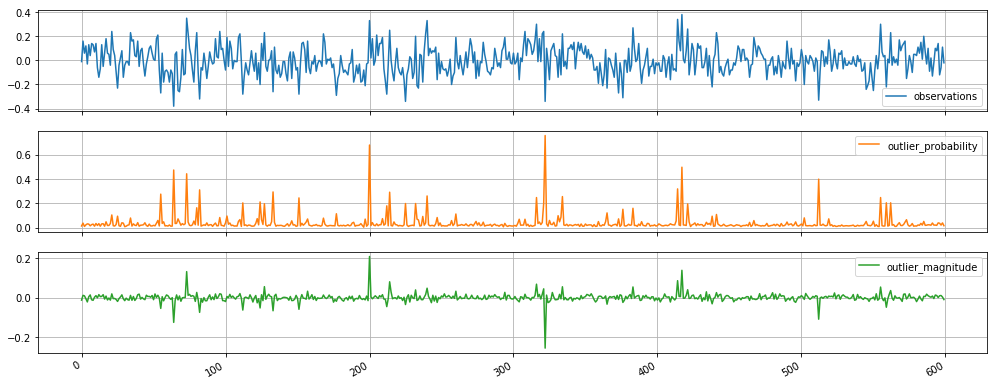

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class OD(object):
    
    def initDataFilePath(self,):
        self.DataFilePath = "w-gs3c.txt"
        
    def __init__(self):
        
        self.niters=10;#number of iterations
        self.nburnin=5#burnin samples
        
        self.initDataFilePath()
        df=pd.read_csv(self.DataFilePath)
        
        self.nrows=len(df.index)
        self.yt=df['t3y'].values
        
        #model choices
        self.p=3#order of the AR process for xt
        self.epsilon=0.05
        #initial value of phi mean
        #self.phi0=np.array([0,0.22,0.02,0.11]).reshape(1,4)
        self.phi0=np.zeros((1,4))
        self.sigma0=np.eye(self.p+1)*0.25
        self.sigma0_inv = np.linalg.inv(self.sigma0)
        
        self.gamma1_prior=5
        self.gamma2_prior=95
        
        self.xi2=0.1
        self.nu=5 #initial value for degrees of freedom
        self.lambdapar=0.00256#scaling factor for chi square
        
        #iteration variables
        self.cur_gamma1=5
        self.cur_gamma2=95
        self.cur_epsilon=np.array([0.05])
        self.cur_phi_sample=np.zeros_like(self.phi0)
        self.cur_sigma2_sample=np.array([0.012])
        self.iternum=0#iterations that have elapsed
        self.cur_xt=np.zeros_like(self.yt)
        self.cur_delta_vec=np.zeros_like(self.yt)#current delta_vec samples
        self.cur_deltah_probs=np.zeros_like(self.yt)#current delta_vec outlier probs
        self.cur_beta_vec=np.zeros_like(self.yt)#current value of beta_vec oulier mag
        self.cur_wvec_r=None
        self.cur_xtmat=None
        self.cur_xtmat_aug=None
        self.cur_beta_mean=None
        self.cur_beta_sigma=None
        
        #cumulative vectors for computing averages
        self.cur_cumul_phi_sample=np.zeros_like(self.cur_phi_sample)
        self.cur_cumul_sigma2_sample=np.zeros_like(self.cur_sigma2_sample)
        self.cur_cumul_beta_mean=np.zeros_like(self.yt)
        self.cur_cumul_beta_sigma=np.zeros_like(self.yt)
        self.cur_cumul_epsilon=np.zeros_like(self.cur_epsilon)
        
        self.cur_cumul_delta_vec=np.zeros_like(self.yt)
        self.cur_cumul_deltah_vec=np.zeros_like(self.yt)
        self.cur_cumul_beta_vec=np.zeros_like(self.yt)
        
        #average vectors
        self.cur_avg_phi_sample=np.zeros_like(self.cur_phi_sample)
        self.cur_avg_sigma2_sample=np.zeros_like(self.cur_sigma2_sample)
        self.cur_avg_beta_mean=np.zeros_like(self.yt)
        self.cur_avg_beta_sigma=np.zeros_like(self.yt)
        self.cur_avg_epsilon=np.zeros_like(self.cur_epsilon)
        
        self.cur_avg_delta_vec=np.zeros_like(self.yt)
        self.cur_avg_deltah_vec=np.zeros_like(self.yt)
        self.cur_avg_beta_vec=np.zeros_like(self.yt)
        
        #posterior params
        self.cur_phiparams=()#tuple containing the phi mean and covar
        np.random.seed(seed=10)
        
        
    #strided rolling window in numpy for fast rolling window calcs
    def rolling_window2(self,a, window):
        '''
        given an array return a rolling window of size p
        there are n-p+1 windows in total, 
        to get n windows pad zeros at the end        
        '''
        
        a=np.append(a,np.zeros((window-1)))
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rw= np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return(rw)
    
        
    def xtToMatrix(self):
        ''' 
        xt-1 matrix in the paper
        first column is (1,x[p-1],...x[0]).T        
        last column is (1,x[n-2],...x[n-p-1]).T                
        note that the implementation assumes the presence of a constant
        term in the AR model
        '''
        xt=self.cur_xt
        p=self.p
        n=self.nrows
        
        xtmat=np.zeros((p+1,(n-1-p+1)))
        
        for i in range(p-1,n-1):
            xtmat[1:,i-(p-1)]=xt[i-p+1:i+1][::-1].reshape(p,)# first element of each column is i-1
            
        xtmat[0,:]=1
        self.cur_xtmat=xtmat
        
    def augmentxtmat(self):
        
        p=self.p
        xt=self.cur_xt
        xtmat=self.cur_xtmat

        extracols=[]
        for i in range(0,p):
            if xt[0:i].shape[0]==0:
                extracols.append(np.zeros((p,1)))
            else:
                extracols.append(np.concatenate(( xt[0:i][::-1].reshape(xt[0:i].shape[0],1),np.zeros((p-i,1)))))

        extracols = np.concatenate(extracols,axis=1)
        extracols = np.concatenate((np.ones((1,p)),extracols),axis=0)
        self.cur_xtmat_aug = np.concatenate((extracols,xtmat),axis=1 )            
        
    def updateX(self):
        self.cur_xt = self.yt - self.cur_delta_vec*self.cur_beta_vec
        
    def posteriorPhiParamNew(self):
        '''
        Mean and Variance of Phi Param
        '''
        p=self.p
        n=self.nrows
        xtmat = self.cur_xtmat
        sigma2 = self.cur_sigma2_sample
        sigma0_inv = self.sigma0_inv
        phi0=self.phi0.T
        
        tmp = np.matmul(xtmat,xtmat.T)
        matprodinv = np.linalg.inv(tmp)
        tmp2=np.matmul(xtmat,self.cur_xt[p:n]).reshape(p+1,1)
        phihat=np.matmul(matprodinv,tmp2)
        
        tmp3=tmp/sigma2
        covar_inv= tmp3 + sigma0_inv
        covar = np.linalg.inv(covar_inv)
        
        phi=np.matmul(tmp3,phihat) + np.matmul(sigma0_inv,phi0)
        phi=np.matmul(covar,phi)
        return(phi,covar)
                
  
            
    def posteriorPhiSample(self,phiparams):
        '''
        draw samples from multivariate normal
        '''
        phi,covar=phiparams
        d=covar.shape[0]
        return( np.random.multivariate_normal(phi.reshape(d,),covar))
    

    def updatewVec(self):
        '''
        compute wj vector which is xt-phi*xt-1
        '''
        self.augmentxtmat()
        xtmataug=self.cur_xtmat_aug
        
        wvec = self.yt.reshape(xtmataug.shape[1],) - np.matmul(self.cur_phi_sample,xtmataug).reshape(xtmataug.shape[1],)
        w_vec_r = self.rolling_window2(wvec,self.p+1)       
        
        self.cur_wvec_r= w_vec_r
        
    def deltaProb(self):
       
        beta_vec=self.cur_beta_vec
        phi=self.cur_phi_sample
        sigma2=self.cur_sigma2_sample
        p=self.p
        epsilon=self.epsilon
        n=self.nrows
        w_vec_r = self.cur_wvec_r
        
        beta_vec_r = np.repeat(beta_vec,p+1).reshape(n,p+1)
        
        #as the summation goes up onlyy to min(n-1,h+p) for h=n-3 onwards we have
        #to set the betas to zero to achieve this
        for i in range(0,p):
            beta_vec_r[n-1-i,i+1:]=0
        
        psi=phi.copy()
        psi[0]=-1
    
        
        tmp = (w_vec_r + psi * beta_vec_r) **2 /2/sigma2
        
        num =  epsilon * np.exp( -np.sum(tmp,axis=1) )
        den =  (num+(1-epsilon)*np.exp(-np.sum(w_vec_r**2/2/sigma2,axis=1 )))
        ans =  num/den
                 
        return(ans)
        

    def posteriordeltaSamples2(self,deltaProb):
        '''
        samples from binomial   
        '''
        
        return( np.random.binomial(1,deltaProb,size=deltaProb.shape[0]) )        
            
    def posteriorEpsilonParam(self):
        '''
        deltas are from a bernoulli
        posterior is as per conjugate priors defined in Tsay, result 3 chap12
        '''
        n=self.nrows
        p=self.p
        delta_vec=self.cur_delta_vec[p:]
        gamma1 = self.gamma1_prior
        gamma2 = self.gamma2_prior
        
        delta_avg=np.mean(delta_vec)
        newgamma1 = gamma1 + (n-p)*delta_avg
        newgamma2 = gamma2 + (n-p)*(1-delta_avg)
        return(newgamma1,newgamma2)
        
    def posteriorEpsilonSample(self,gamma1,gamma2):
        '''
        posterior is as per conjugate priors as defined in Tsay result 3, chapter 12
        '''
        return(np.random.beta(gamma1,gamma2))

    def betaDistParamNew(self):
        '''
        update the beta distributions mean and variance        
        different means and variances baed on delta=0 or 1
        '''
        p=self.p
        xi2=self.xi2
        sigma2=self.cur_sigma2_sample
        #beta_vec=self.cur_beta_vec2
        psi=self.cur_phi_sample.copy()
        psi[0]=-1
        delta_vec=self.cur_delta_vec
        n=self.nrows
        w_vec_r = self.cur_wvec_r
        
        psi2=psi**2
        num  =  -xi2 * np.sum(psi*w_vec_r,axis=1)
        den = np.zeros_like(num) + np.sum(psi2)
        
        for i in range(0,p):
            den[n-1-i]=np.sum(psi2[0:i+1])
        
        den= den*xi2 + sigma2
        
        betamean_new = num/den
        sigmabeta_new = sigma2*xi2/den
        
        betamean_new=delta_vec * betamean_new + (1-delta_vec)*0
        sigmabeta_new = delta_vec * sigmabeta_new +(1-delta_vec)*xi2
        
        return(betamean_new,sigmabeta_new)    
        
        
    def getBetaParamPostSamples(self,betamean,sigmabeta,n):
        '''
        Posterior samples for beta parameter
        '''
        return( np.random.normal(loc=betamean,scale=np.sqrt(sigmabeta),size=n))
            
    def posteriorSigma2Sample(self):
        '''
        draw posterior samples for sigma2
        '''        
        p=self.p
        n=self.nrows
        phi=self.cur_phi_sample.copy()
        nu=self.nu
        lambdapar=self.lambdapar
        x_vec=self.cur_xt
        xtmat=self.cur_xtmat
        
        #we leave the 0 to p-1 entries from x_vec
        #as this is how a_vec is defined
        a_vec = x_vec[p:] - np.matmul(phi.reshape(1,p+1),xtmat).T.reshape(x_vec[p:].shape)
        a_vec = a_vec**2
        
        sample = np.random.chisquare(nu+n-p,size=1)
        sigma2_new = (nu*lambdapar + np.sum(a_vec))/sample
        return(sigma2_new)    
            
    def updateCumulVector(self):
        
        if self.iternum > self.nburnin:
            self.cur_cumul_delta_vec += self.cur_delta_vec
            self.cur_cumul_deltah_vec += self.cur_deltah_probs
            self.cur_cumul_phi_sample += self.cur_phi_sample
            
            self.cur_cumul_sigma2_sample += self.cur_sigma2_sample
            self.cur_cumul_beta_vec += self.cur_beta_vec
            self.cur_cumul_beta_mean += self.cur_beta_mean
            self.cur_cumul_beta_sigma += self.cur_beta_sigma
            self.cur_cumul_epsilon += self.cur_epsilon
            
    def gibbsMean(self):
        
        niter =self.niters-self.nburnin+1
        if self.iternum > self.nburnin:
            self.cur_avg_delta_vec += self.cur_cumul_delta_vec/niter
            self.cur_avg_deltah_vec += self.cur_cumul_deltah_vec/niter
            self.cur_avg_phi_sample += self.cur_cumul_phi_sample/niter
            
            self.cur_avg_sigma2_sample += self.cur_cumul_sigma2_sample/niter
            self.cur_avg_beta_vec += self.cur_cumul_beta_vec/niter
            self.cur_avg_beta_mean += self.cur_cumul_beta_mean/niter
            self.cur_avg_beta_sigma += self.cur_cumul_beta_sigma/niter
            self.cur_avg_epsilon += self.cur_cumul_epsilon/niter
        
    def plotResults(self):
        print('Avg Phi:',self.cur_avg_phi_sample)
        print('Avg sigma2:',self.cur_avg_sigma2_sample)
        tmp=pd.DataFrame()
        tmp['observations']=self.yt
        tmp['outlier_probability']=self.cur_avg_delta_vec
        tmp['outlier_magnitude']=self.cur_avg_beta_vec
        plt.rcParams["figure.figsize"] = (17,7)

        tmp.plot(subplots=True,grid=True)
        
    def oneGibbsIteration(self,):
            
        #step1:update conditional phi distribution
        self.updateX()
        self.xtToMatrix()
        self.cur_phiparams=self.posteriorPhiParamNew()
        self.cur_phi_sample=self.posteriorPhiSample(self.cur_phiparams)
        
        #step2: update conditional probability of delta=1
        self.updatewVec()
        self.cur_deltah_probs=self.deltaProb()
        self.cur_delta_vec=self.posteriordeltaSamples2(self.cur_deltah_probs)        
        
        #step3:update epsilon because it is only dependent on y and delta
        self.cur_gamma1,self.cur_gamma2 = self.posteriorEpsilonParam()
        self.cur_epsilon = self.posteriorEpsilonSample(self.cur_gamma1,self.cur_gamma2)
        
        #step4:update beta
        self.cur_beta_mean,self.cur_beta_sigma = self.betaDistParamNew()
        self.cur_beta_vec = self.getBetaParamPostSamples(self.cur_beta_mean,self.cur_beta_sigma,self.nrows)
        
        #step5:update X with new phi,delta, beta
        self.updateX()
        self.xtToMatrix()
        self.updatewVec()
        
        #step6:update sigma2
        self.cur_sigma2_sample = self.posteriorSigma2Sample()
        self.iternum +=1
        self.updateCumulVector()                                 
        
        
    def runGibbsSampling(self):
        for i in range(1,self.niters+1):
            self.oneGibbsIteration()
        
        self.gibbsMean()
        

a=OD()
a.niters=1050
a.nburnin=50
#a.oneGibbsIteration()
a.runGibbsSampling()
a.plotResults()     
 